In [1]:
%%shell

wget "https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz"
tar -xzvf cora.tgz

pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
pip install torch-geometric

pip install networkx

pip install icecream
pip install tqdm

--2021-11-20 06:53:13--  https://web.archive.org/web/20150918182409/http://www.cs.umd.edu/~sen/lbc-proj/data/cora.tgz
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘cora.tgz’

cora.tgz                [   <=>              ] 163.15K   363KB/s    in 0.4s    

2021-11-20 06:53:18 (363 KB/s) - ‘cora.tgz’ saved [167063]

cora/
cora/README
cora/cora.content
cora/cora.cites
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
     |████████████████████████████████| 291 kB 5.3 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
     |████████████████████████████████| 639 kB 4.8 MB/s 
     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 407 kB 39.8 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
  Created wheel for t

In [124]:
import numpy as np
import pandas as pd
import random
from collections import Counter
from icecream import ic

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric

import networkx as nx
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize

from tqdm.notebook import tqdm

print("Torch version:", torch.__version__)
print("CUDA Present:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

Torch version: 1.10.0+cu111
CUDA Present: False
CUDA Version: 11.1


In [154]:
CONFIG = {
    'PATH': './cora',
    'LIMIT': 250,
    'HIDDEN_CHANNELS': 1024,
    'NUM_LAYERS': 2,
    'DROPOUT_RATE': 0,
    'EPOCHS': 200
}

print("Here's the configuration: ")
for k, v in CONFIG.items():
    print(f"{k} = {v}")

Here's the configuration: 
PATH = ./cora
LIMIT = 250
HIDDEN_CHANNELS = 1024
NUM_LAYERS = 2
DROPOUT_RATE = 0
EPOCHS = 200


In [155]:
class Data:
    def __init__(self, path):
        self.path = path
    
    def readFile(self, path):
        lines = []
        with open(path) as file:
            lines = file.readlines()
        return lines

    def readContent(self, data):
        nodes, labels, x = [], [], []
        for d in data:
            words = d.split("\t")
            nodes.append(words[0].strip())
            labels.append(words[-1].strip())
            x.append([ord(w) - 48 for w in words[1:-1]])

        LE = LabelEncoder()
        labels = LE.fit_transform(labels)
        x_req = torch.Tensor(x)
        # ic(x.shape)
        x = pd.DataFrame.from_records(x)
        
        return nodes, labels, LE, x_req, x

    def getLabels(self, LE, data):
        return LE.inverse_transform(data)

    def readCites(self, data):
        edges = []
        for d in data:
            words = d.split("\t")
            edges.append([
                words[0].strip(),
                words[1].strip()
            ])
        return edges

    def splitDataCount(self, data, labels):
        lcounter = dict((l, 0) for l in labels)
        indices = []
        for i in range(len(labels)):
            label = labels[i]
            if lcounter[label] < CONFIG['LIMIT']:
                indices.append(i)
                lcounter[label] += 1
        rest = [x for x in range(len(labels)) if x not in indices]
        rest = torch.LongTensor(rest)
        indices = torch.LongTensor(indices)
        return rest, indices

    def normalizeMatrix(self, A):
        return scipy.sparse.diags(np.array(A.sum(1)).flatten() ** -1).dot(A)

    def toTensor(self, A):
        A = A.tocoo()
        i = torch.tensor(np.vstack((A.row, A.col)), dtype=torch.long)
        v = torch.tensor(A.data, dtype=torch.float)
        return torch.sparse_coo_tensor(i, v, torch.Size(A.shape))

    def buildGraph(self):
        nodes, edges = self.getGraph()
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_edges_from(edges)
        A = nx.adjacency_matrix(G)
        I = scipy.sparse.identity(A.shape[0])
        A = A + I
        A = self.normalizeMatrix(A)
        A = self.toTensor(A)
        A = A.to_dense()
        ic(A.shape)
        ic(nx.info(G))
        return A, G

    def getIndices(self):
        return self.train, self.test

    def getGraph(self):
        return self.nodes, self.edges

    def getMatrix(self):
        return self.A

    def getXY(self):
        return self.x, torch.LongTensor(self.labels)

    def printData(self):
        print(f"Number of nodes: {len(self.nodes)}")
        print(f"Number of features per node: {len(self.x[0])}")
        print(f"Categories: {set(self.labels)}")

    def handle(self):
        data = self.readFile(self.path + '/cora.content')
        e_data = self.readFile(self.path + '/cora.cites')
        self.nodes, self.labels, self.LE, self.x, self.x_req = self.readContent(data)
        self.edges = self.readCites(e_data)
        self.test, self.train = self.splitDataCount(self.x_req, self.labels)
        self.A, self.G = self.buildGraph()

In [156]:
class MyGATLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        in_channels: #features in the input
        out_channels: #features in the output
        these layers have their *own* independent weights and biases
        """
        super().__init__()
        self.out_channels = out_channels
        
        # W = FxH
        self.W = nn.Parameter(torch.empty(in_channels, out_channels))
        nn.init.xavier_uniform_(self.W, gain=1.414)

        # a = 2Hx1 (So its essentially concating features of 2 nodes)
        # Note: torch.empty does random assignments of value
        self.a = nn.Parameter(torch.empty(size=(2*out_channels, 1)))
        nn.init.xavier_uniform_(self.a, gain=1.414)

        self.leaky = nn.LeakyReLU()
        self.attention = None

    def forward(self, X, A):
        """
        does the neat math on *symmetrically normalized* A
        """

        # Normal feature calculation, Wh = NxH
        wh = torch.mm(X, self.W)

        # wh = NxH, a = 2Hx1, halfA = Hx1
        # both half = NxH * Hx1 = Nx1
        first_half = wh@self.a[self.out_channels:, :]
        second_half = wh@self.a[:self.out_channels, :]

        # Attention matrix formed by combining both halfs
        after = second_half + first_half.T
        after = self.leaky(after)

        # Combining adj matrix and attention matrix
        # Attention should only be a number if connection between nodes exist
        zmat = -1e17*torch.ones_like(after)
        attention = torch.where(A>0, after, zmat)
        attention = F.softmax(attention, dim=1)

        # Multiplication of features with attention
        hprime = torch.matmul(attention, wh)

        # storing for visualisation reasons
        self.attention = attention

        return F.elu(hprime)

In [157]:
class MyGAT(nn.Module):
    def __init__(
            self, 
            in_channels, 
            hidden_channels, 
            num_layers, 
            out_channels, 
            dropout_rate,
            attention_channels,
        ):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.out_channels = out_channels
        self.dropout_rate = dropout_rate
        
        self.MyGATLayers = []
        self.MyGATLayers.append(
            MyGATLayer(self.in_channels, self.hidden_channels)
        )
        self.outputLayers = MyGATLayer(self.hidden_channels, self.out_channels)

        for _ in range(1, self.num_layers):
            self.MyGATLayers.append(
                MyGATLayer(self.hidden_channels, self.hidden_channels)
            )

    def sdMul(self, X, Y):
        i = X._indices()
        v = X._values()
        dv = Y[i[0,:], i[1,:]]
        return torch.sparse.FloatTensor(i, v*dv, X.size())

    def get_attention_matrices(self, yeet=False):
        attention_matrices = [
            layer.attention.detach().numpy() for layer in self.MyGATLayers
        ]
        if yeet: return attention_matrices
        
        I = np.eye(attention_matrices[0].shape[0], attention_matrices[0].shape[1])

        return [
            np.subtract(matrix, I) for matrix in attention_matrices
        ]
    
    def forward(self, X, A):
        """
        math done on *symmetrically normalized* A
        """
        for layer in self.MyGATLayers:
            X = layer.forward(X, A)
        X = F.relu(X)
        X = F.dropout(X, p=self.dropout_rate, training=self.training)
        X = self.outputLayers.forward(X, A)
        return F.log_softmax(X)

In [158]:
dataset = Data(CONFIG['PATH'])
dataset.handle()
X, y = dataset.getXY()
train, test = dataset.getIndices()
A = dataset.getMatrix()
ic(X.shape, y.shape)
ic(train.shape, test.shape)

ic| A.shape: torch.Size([2708, 2708])
ic| nx.info(G): 'Graph with 2708 nodes and 5278 edges'
ic| X.shape: torch.Size([2708, 1433]), y.shape: torch.Size([2708])
ic| train.shape: torch.Size([1647]), test.shape: torch.Size([1061])


(torch.Size([1647]), torch.Size([1061]))

In [159]:
print(f"frequency map: {Counter(y.numpy())}")

frequency map: Counter({2: 818, 3: 426, 1: 418, 6: 351, 0: 298, 4: 217, 5: 180})


In [160]:
model = MyGAT(
    in_channels=X.shape[1],
    hidden_channels=CONFIG['HIDDEN_CHANNELS'],
    num_layers=CONFIG['NUM_LAYERS'],
    out_channels=7,
    dropout_rate=CONFIG['DROPOUT_RATE'],
    attention_channels=A.shape[1]
)

loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [161]:
losses = []
for _ in tqdm(range(CONFIG['EPOCHS'])):
    optimizer.zero_grad()
    output = model.forward(X, A)
    train_x = torch.index_select(output, 0, train)
    train_y = torch.index_select(y, 0, train)
    l = loss(train_x, train_y)
    l.backward()
    losses.append(l.item())
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [162]:
losses # benchmark

[1.959848165512085,
 1.9467955827713013,
 1.9338105916976929,
 1.920880675315857,
 1.9079865217208862,
 1.8951102495193481,
 1.8822333812713623,
 1.869348168373108,
 1.8564478158950806,
 1.843531847000122,
 1.8306047916412354,
 1.8176676034927368,
 1.8047233819961548,
 1.7917736768722534,
 1.7788214683532715,
 1.7658753395080566,
 1.752943515777588,
 1.7400329113006592,
 1.7271523475646973,
 1.714313268661499,
 1.7015262842178345,
 1.6887997388839722,
 1.6761432886123657,
 1.6635645627975464,
 1.6510683298110962,
 1.6386590003967285,
 1.6263424158096313,
 1.6141213178634644,
 1.60199773311615,
 1.5899702310562134,
 1.578041434288025,
 1.566211462020874,
 1.5544782876968384,
 1.5428433418273926,
 1.5313053131103516,
 1.5198655128479004,
 1.5085235834121704,
 1.4972774982452393,
 1.4861279726028442,
 1.4750744104385376,
 1.464116096496582,
 1.453253984451294,
 1.4424864053726196,
 1.4318147897720337,
 1.421238899230957,
 1.4107589721679688,
 1.4003759622573853,
 1.3900902271270752,
 1.37

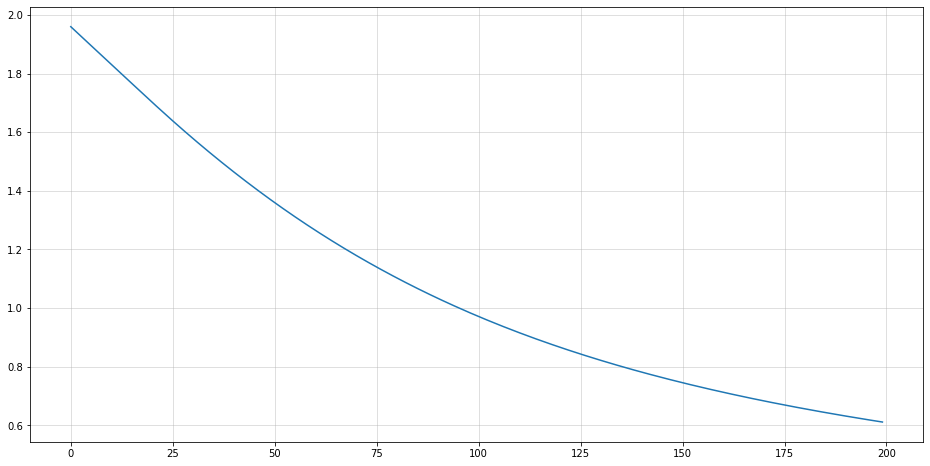

In [163]:
plt.figure(figsize=(16,8))
plt.plot(losses)
plt.grid(alpha=0.5)
plt.show()

In [164]:
output = model.forward(X, A)
test_x = torch.index_select(output, 0, test)
test_y = torch.index_select(y, 0, test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [165]:
predictions = torch.argmax(test_x, dim=1)

In [166]:
predictions.shape

torch.Size([1061])

In [167]:
predictions, test_y = predictions.numpy(), test_y.numpy()

In [168]:
acc = 0
for i in range(len(test_y)):
    if predictions[i] == test_y[i]:
        acc += 1
ic(acc/len(test_y)*100)

ic| acc/len(test_y)*100: 82.3751178133836


82.3751178133836

In [169]:
torch.save(model.state_dict(), f"model_save_{round(acc/len(test_y)*100, 3)}.model")

In [170]:
predictions

array([2, 2, 2, ..., 1, 0, 2])

In [171]:
test_y

array([2, 2, 2, ..., 1, 0, 2])

In [172]:
from collections import Counter
c = Counter(predictions)
print(c)

Counter({2: 468, 3: 207, 1: 162, 6: 132, 0: 64, 4: 17, 5: 11})


In [173]:
from collections import Counter
c = Counter(test_y)
print(c)

Counter({2: 568, 3: 176, 1: 168, 6: 101, 0: 48})


In [174]:
import matplotlib.pyplot as plt

In [175]:
def get_attention_matrices():    
    X, y = dataset.getXY()
    A = dataset.getMatrix()
    
    attention_matrices = None
    with torch.no_grad():
        attention_matrices = model.get_attention_matrices(yeet=True)
    return attention_matrices

attention_matrices = get_attention_matrices()

# DEBUGGING INFORMATION
# ic(X.shape)
# ic(A.shape)
# ic(output.shape)
# ic(len(attention_matrices))
# ic(attention_matrices[-1].shape)

In [176]:
def get_class_rows(matrix, class_label=1):
    n = len(X)
    indices = [int(y[i] == class_label) for i in range(n)]
    return np.array(indices)

(42, 42)


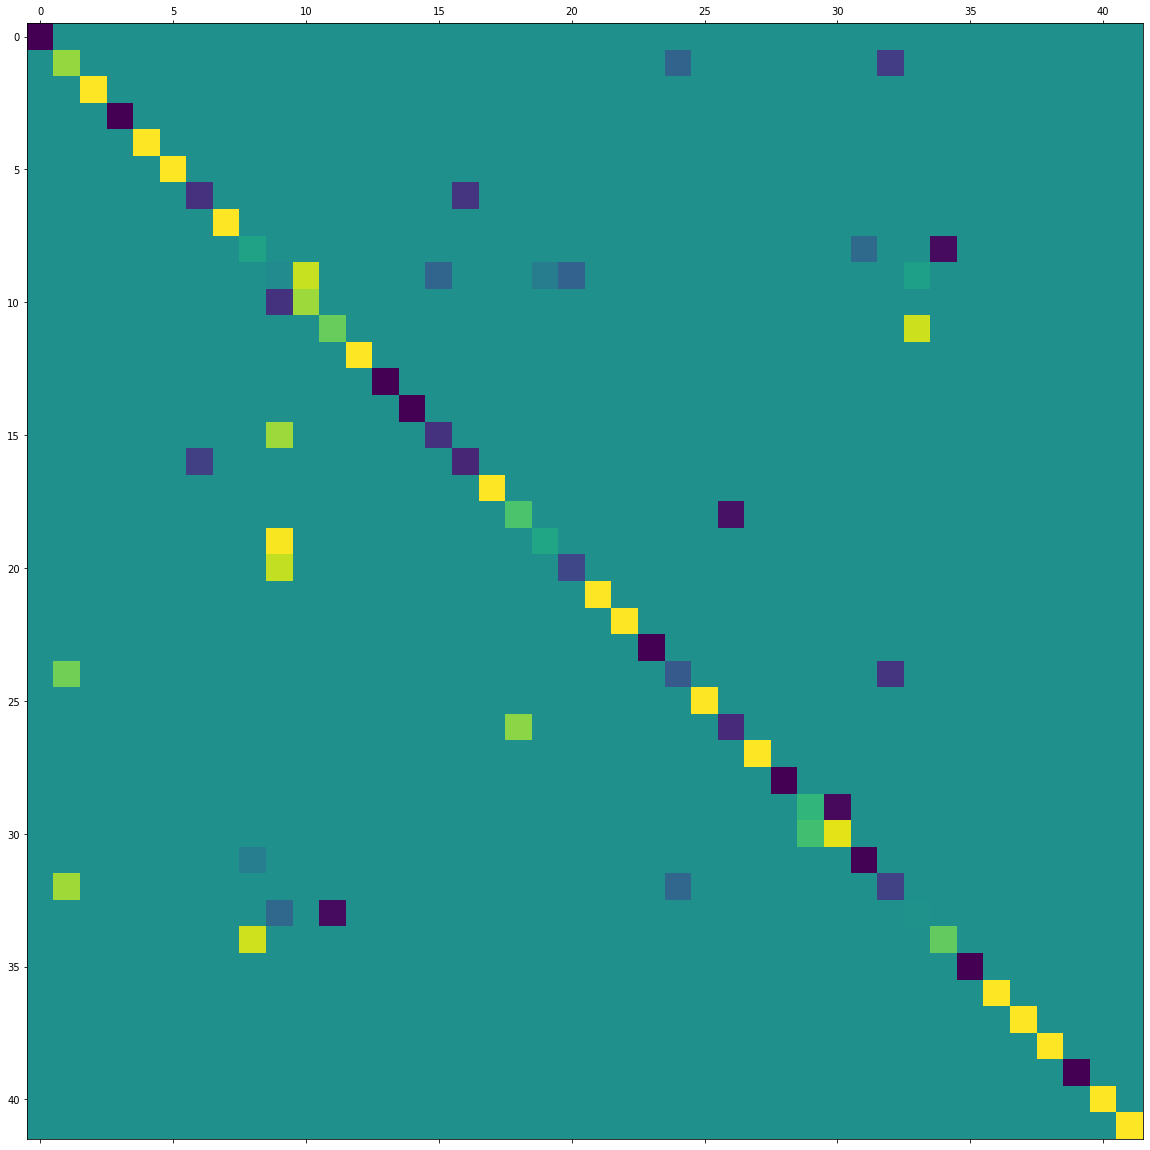

(42, 42)


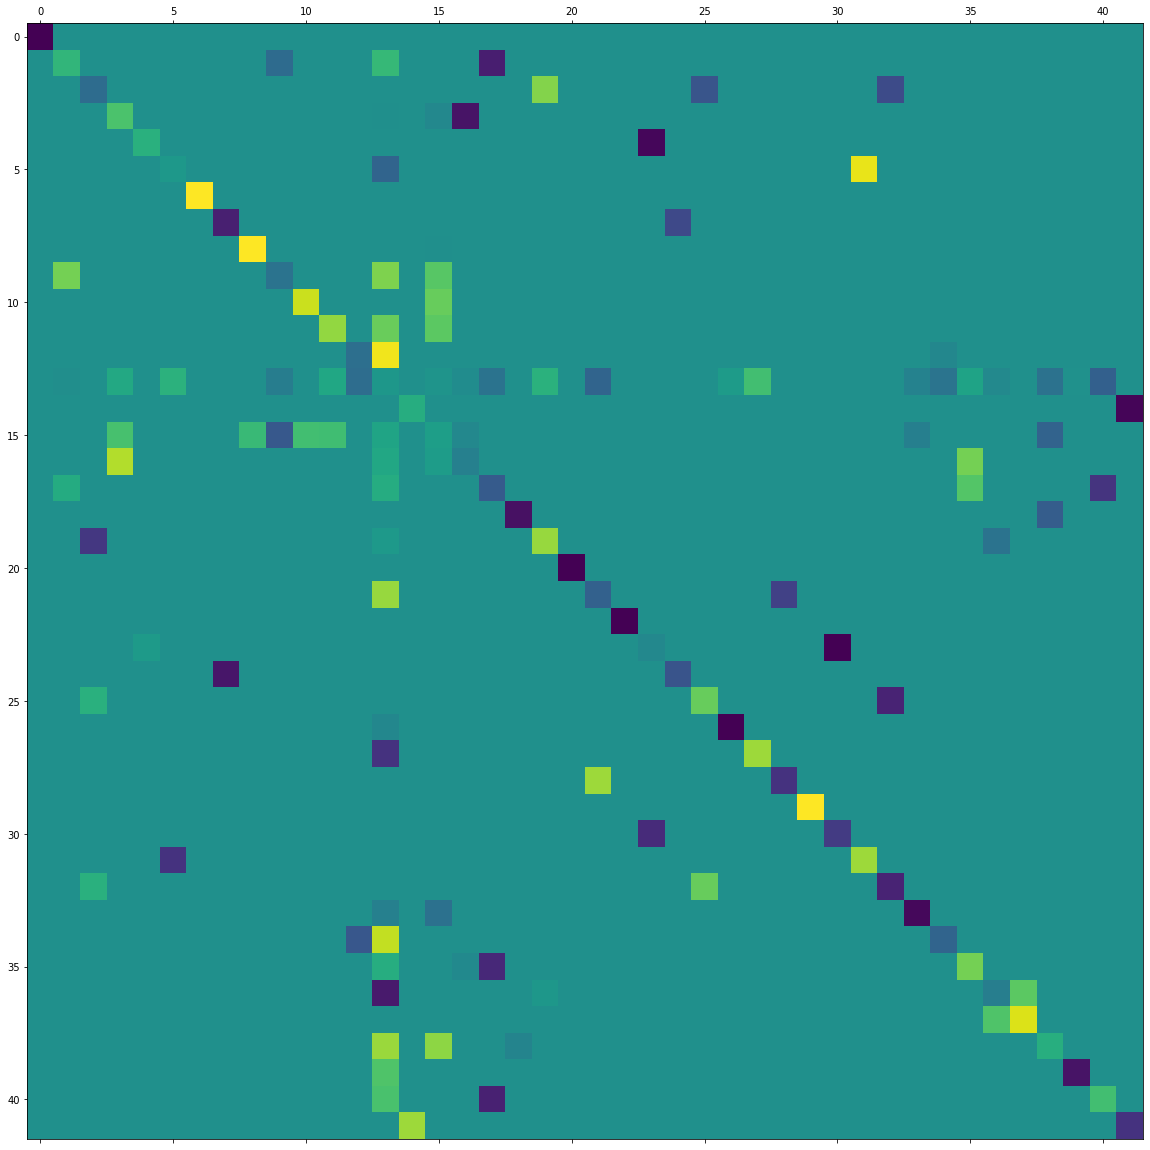

(42, 42)


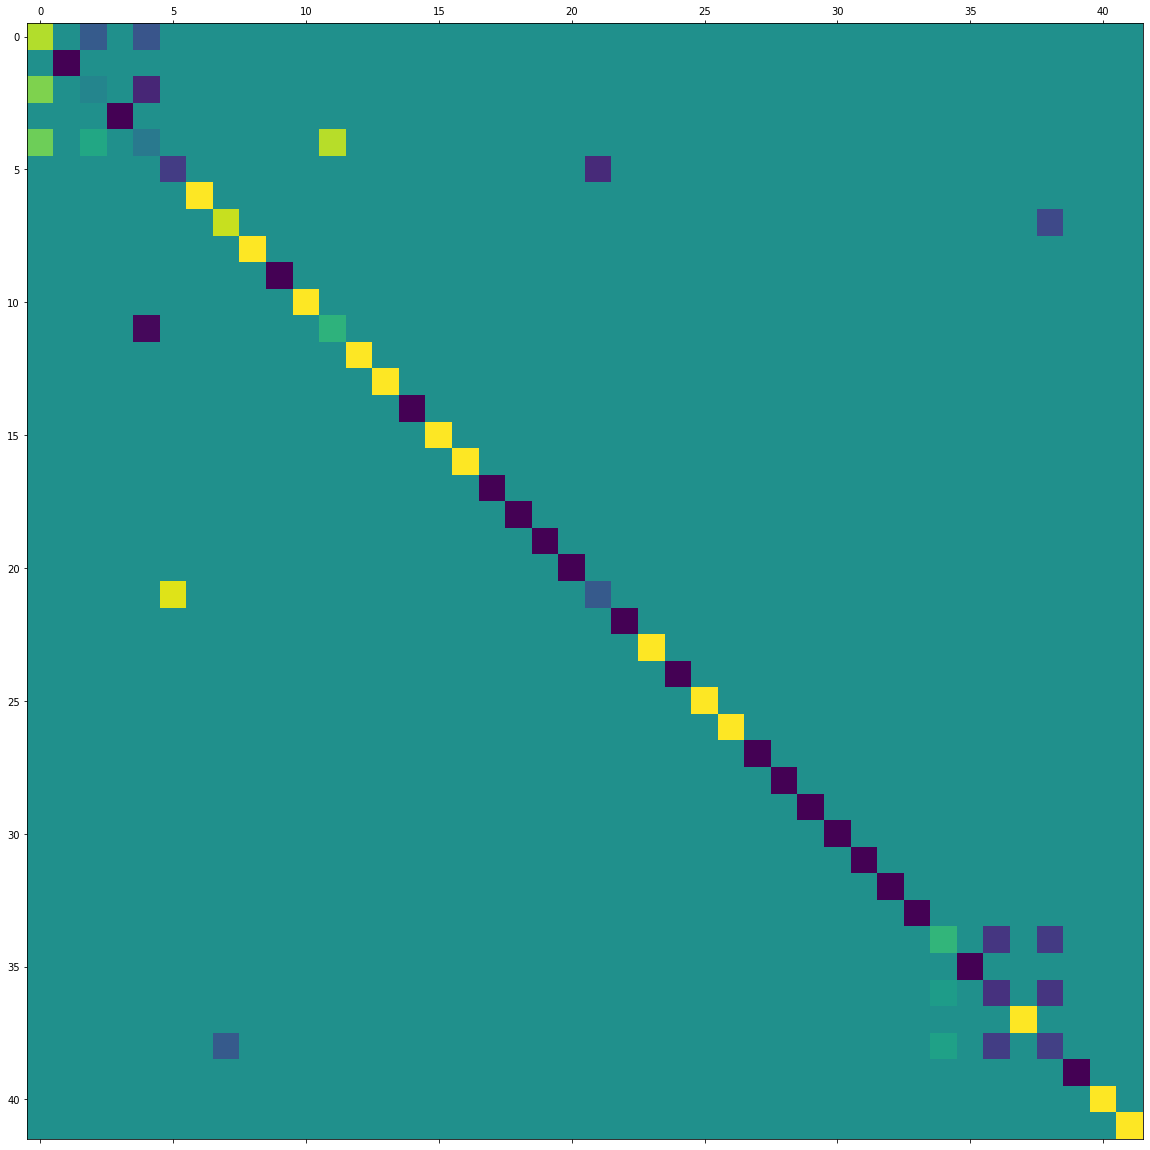

(42, 42)


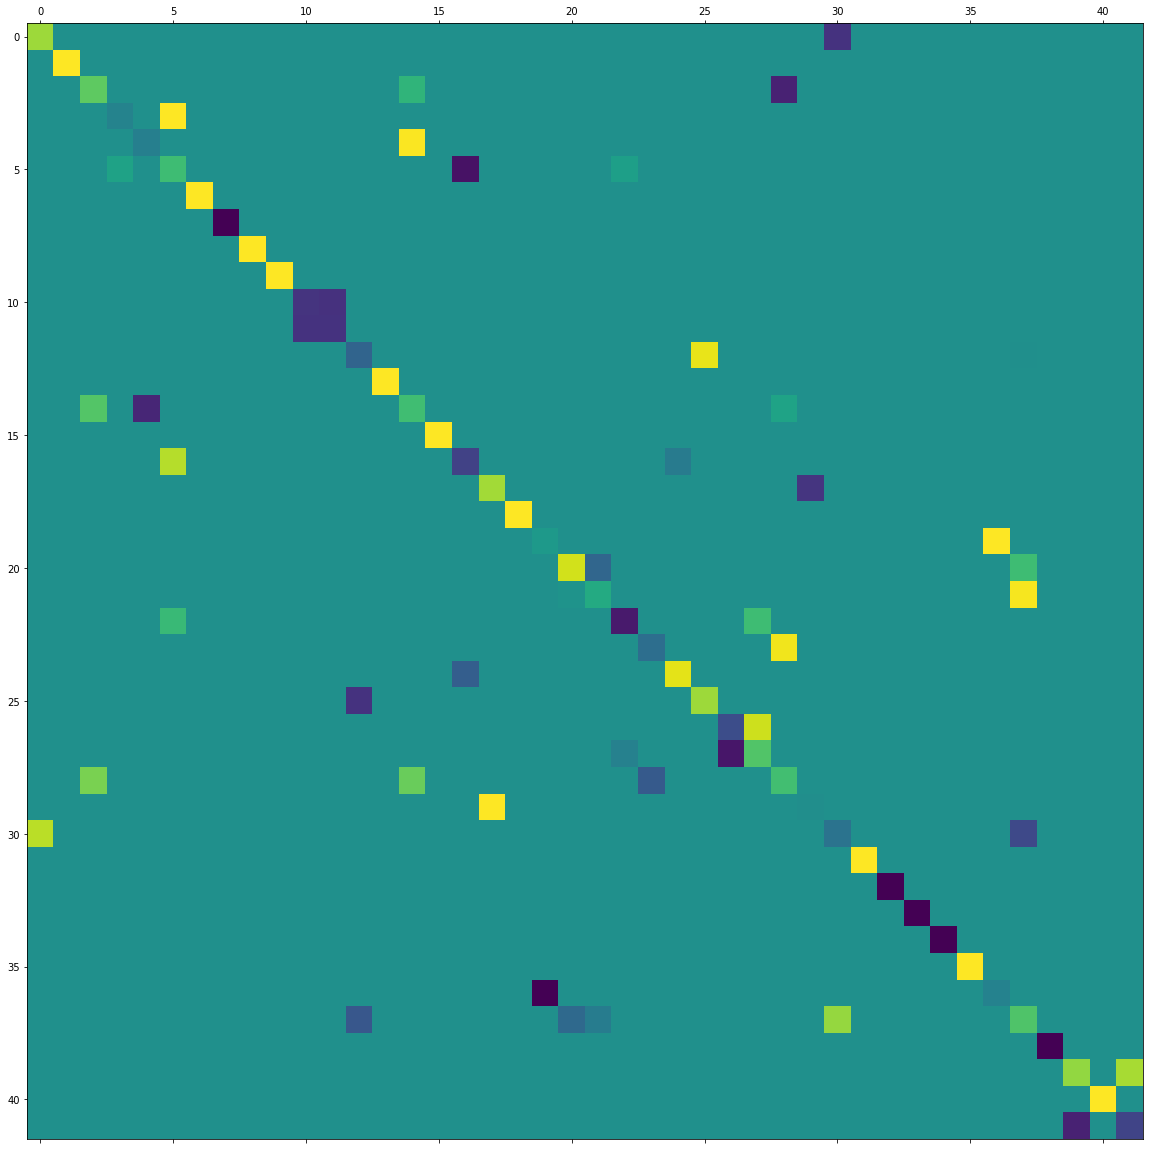

(42, 42)


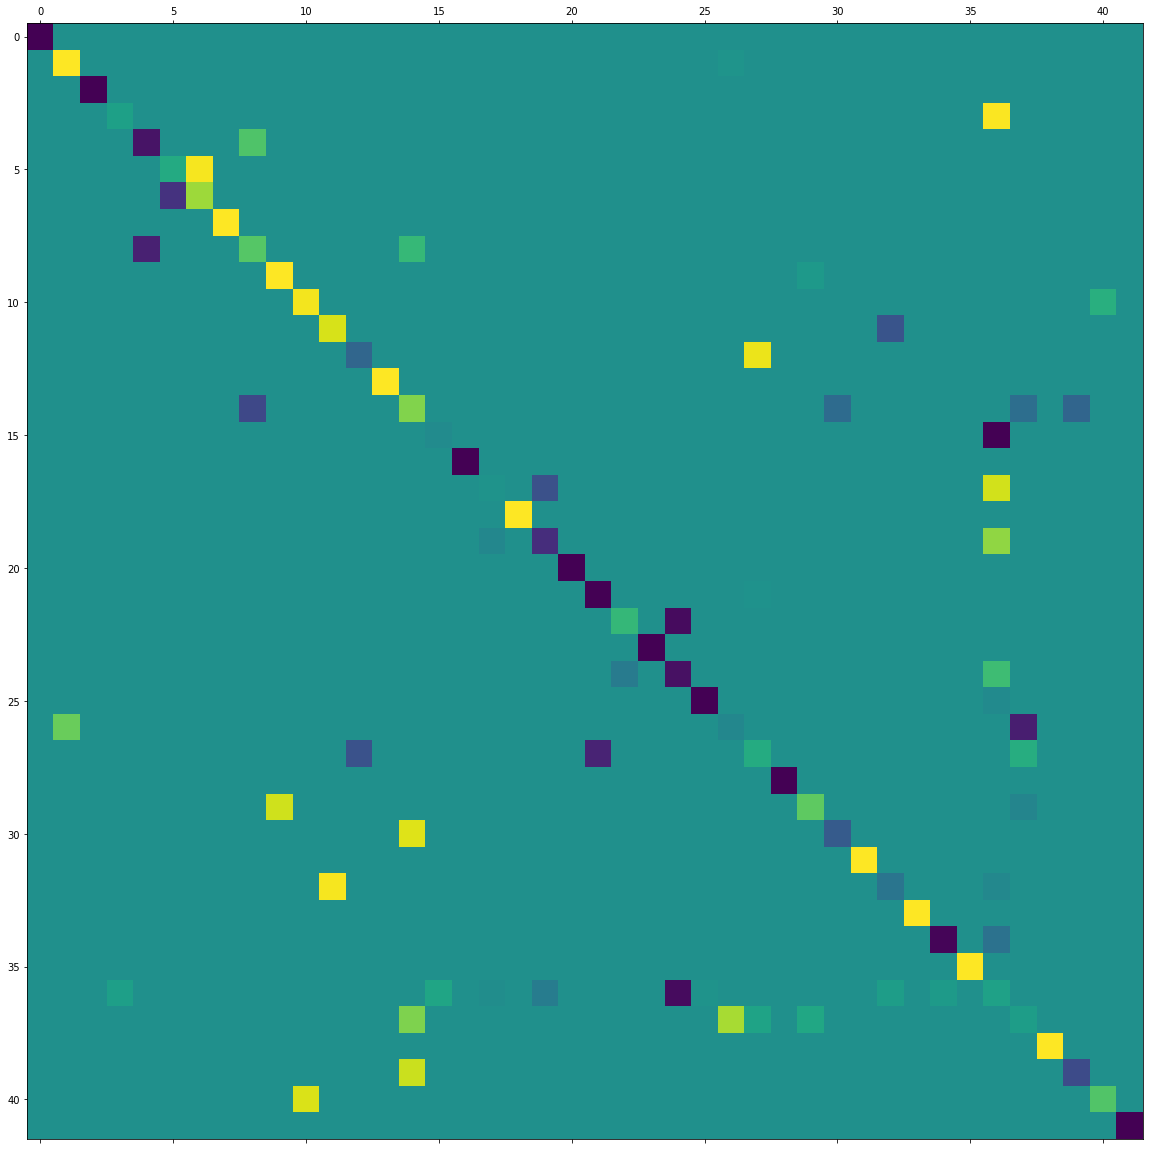

(42, 42)


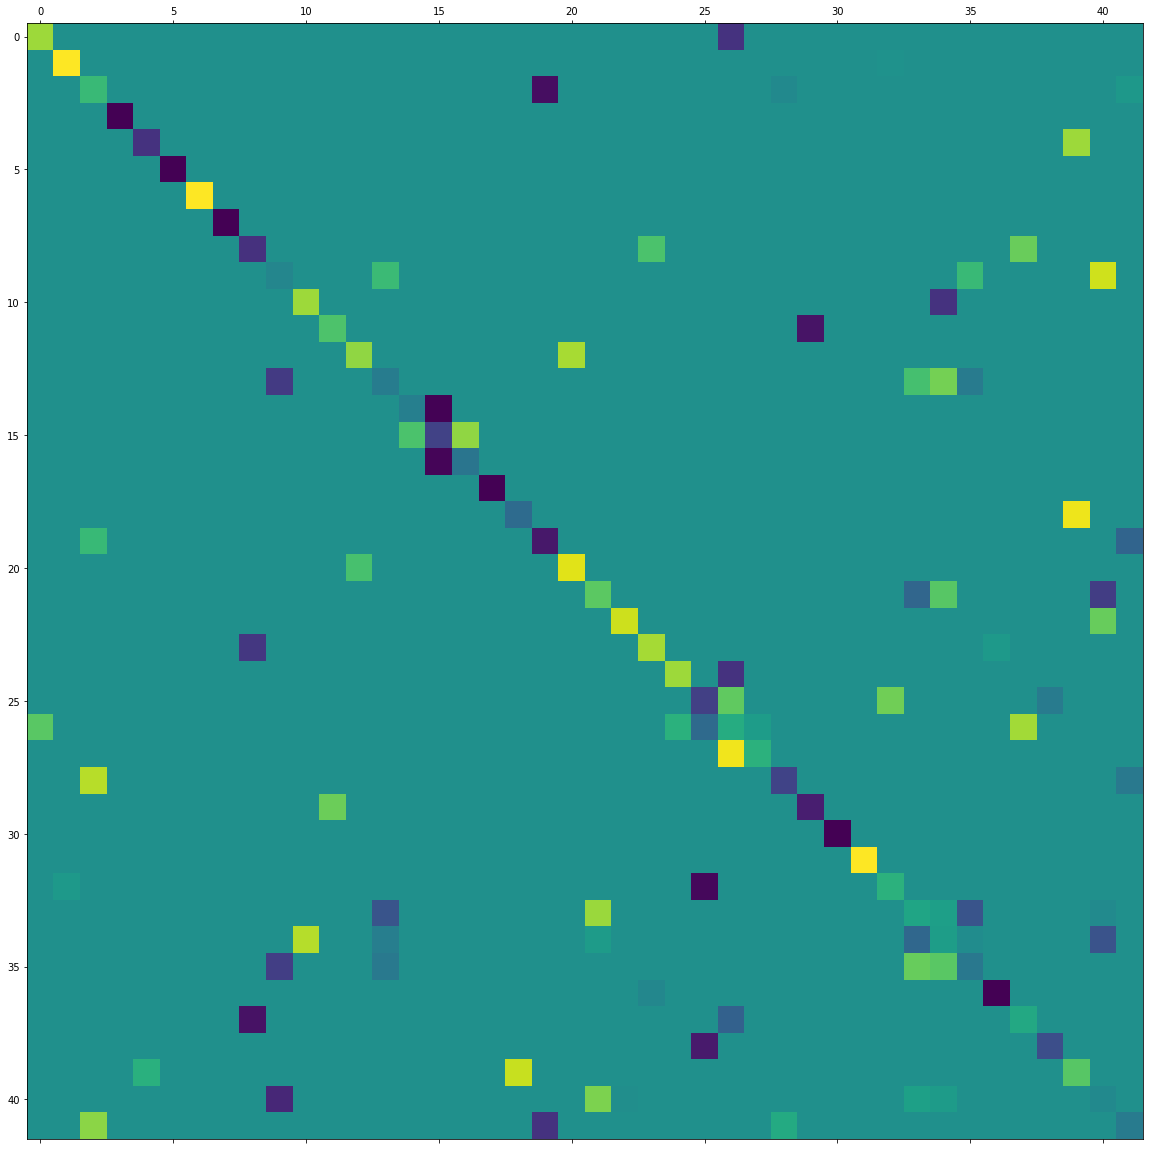

(42, 42)


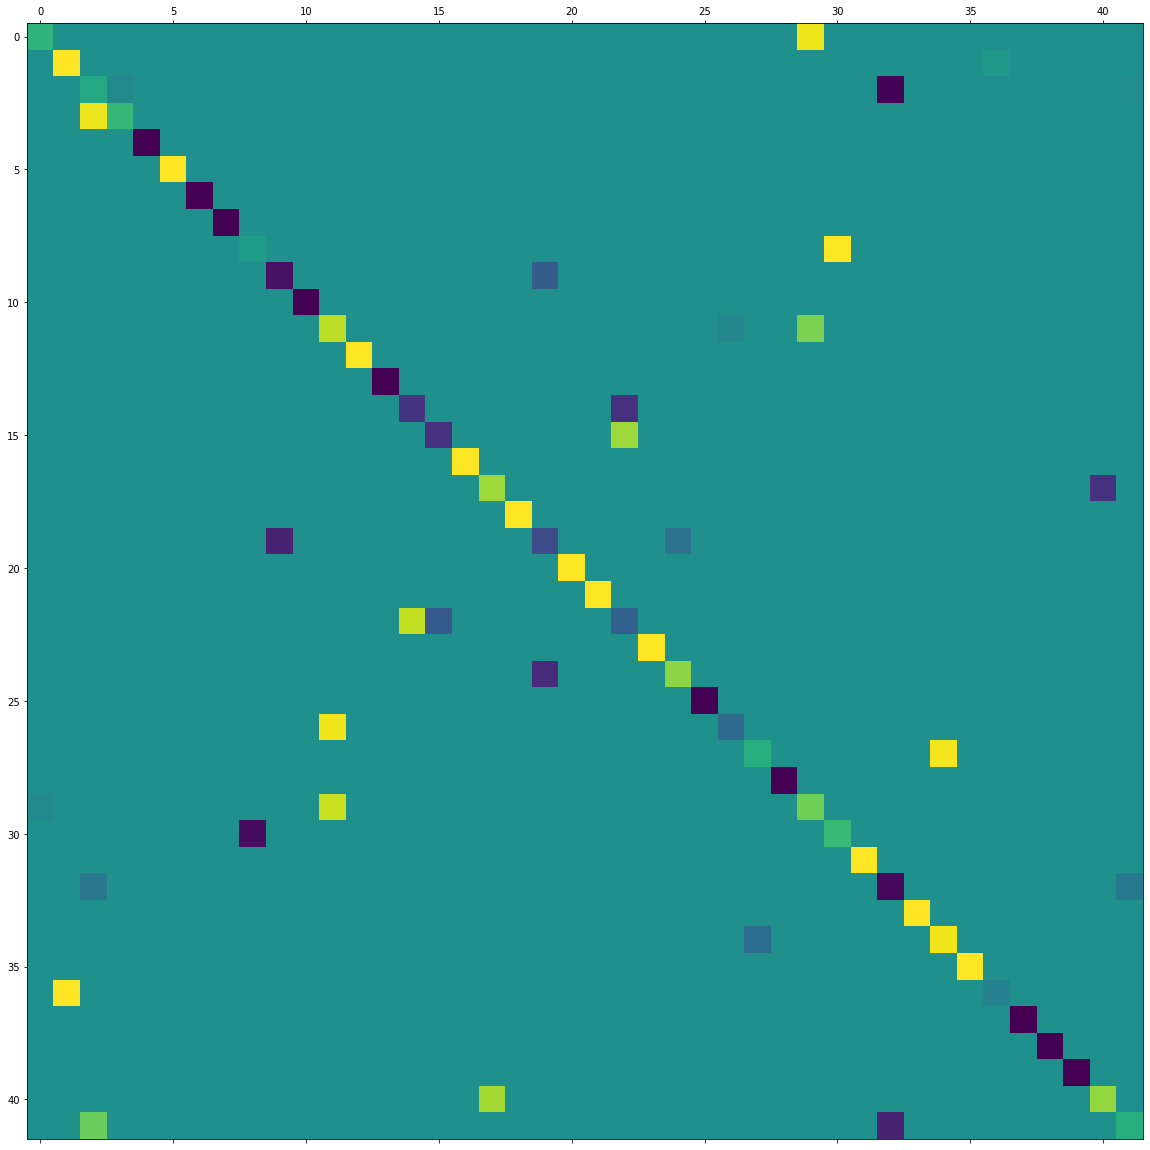

In [190]:
def plot_matrix(matrix, label, filter_class=None):
    start_point_x, start_point_y = 0, 0
    end_point_x, end_point_y = 42, 42

    if filter_class is not None:
        indices = get_class_rows(matrix, filter_class)
        # print(indices)

        new_mat = []
        m, n = len(matrix), len(matrix[0])
        for i in range(m):
            if indices[i]:
                new_row = []
                for j in range(n):
                    if indices[j]: 
                        new_row.append(matrix[i][j])
                new_mat.append(np.array(new_row)[start_point_y:end_point_y])
        matrix = np.array(new_mat)[start_point_x:end_point_x]
    

    matrix = normalize(matrix, axis=1)
    print(matrix.shape)
    plt.figure(figsize=(20,20))
    plt.matshow(matrix, fignum=1, cmap=plt.get_cmap("viridis"))
    # plt.title(label)
    # plt.legend()
    plt.show()

# plot_matrix(attention_matrices[0], "first attention matrix", filter_class=None)
# plot_matrix(attention_matrices[-1], "last attention matrix", filter_class=None)
for i in range(7):
    plot_matrix(np.subtract(attention_matrices[-1], attention_matrices[0]), "", filter_class=i)

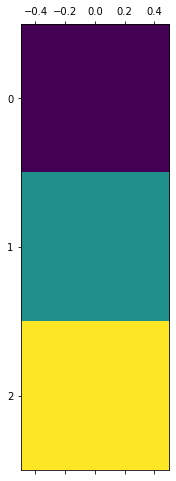

In [178]:
matrix = [[-1], [0], [1]]
plt.figure(figsize=(8,8))
plt.matshow(matrix, fignum=1, cmap=plt.get_cmap("viridis"))